In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.feedback as feedback
import grale.grid as grid
import grale.renderers as renderers
import grale.plotutil as plotutil
from grale.cosmology import Cosmology
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

V = lambda x,y: np.array([x,y],dtype=np.double)

feedback.setDefaultFeedback("none")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)
renderers.setDefaultLensPlaneRenderer("openmp")
renderers.setDefaultMassRenderer("openmp")

cosm = Cosmology(0.7,0.3,0,0.7)

In [2]:
zd = 0.5
zs = 2.0

Dd = cosm.getAngularDiameterDistance(zd)
Dds = cosm.getAngularDiameterDistance(zd,zs)
Ds = cosm.getAngularDiameterDistance(zs)
critDens = lenses.getCriticalDensity(Dd, Ds, Dds)

l = lenses.PIEMDLens(Dd, { 
    "centraldensity": 30*critDens,
    "coreradius": 0.5*ANGLE_ARCSEC,
    "scaleradius": 50*ANGLE_ARCSEC,
    "epsilon": 0.3})

In [3]:
bl = V(-80,-80)*ANGLE_ARCSEC
tr = -bl

lensInfo = { "lens": l, "Dds": Dds, "Ds": Ds, "bottomleft": bl, "topright": tr, "numx": 1023, "numy": 1023 }

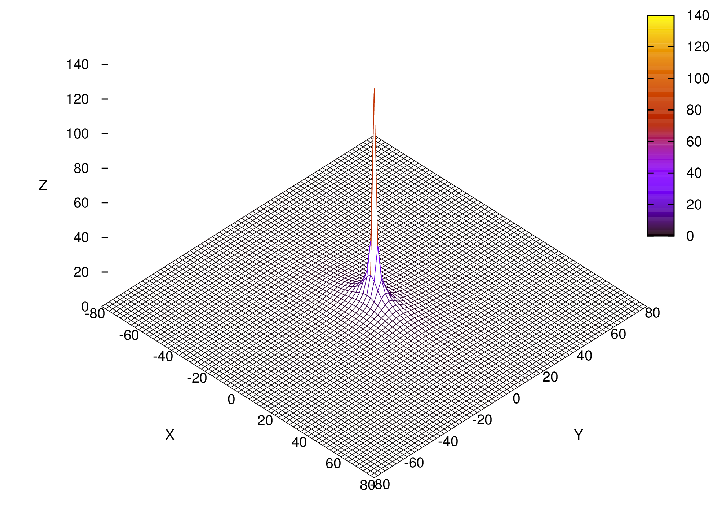

In [4]:
plt.figure(figsize=(12,12))
plotutil.plotDensityGnuplot(lensInfo);

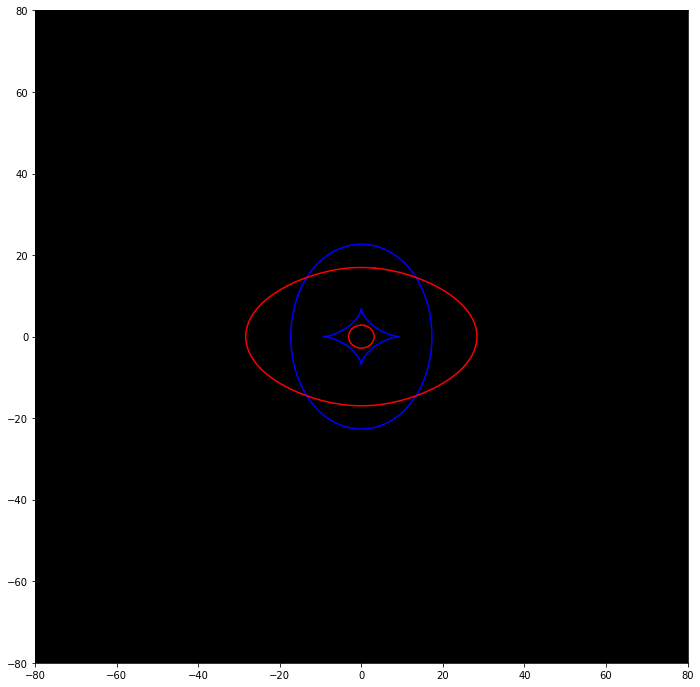

In [5]:
plt.figure(figsize=(12,12))
plotutil.plotImagePlane(lensInfo);

In [6]:
N=2000
cells = grid.createSubdivisionGrid(120*ANGLE_ARCSEC, [0,0], lensInfo, N, N+200, keepLarger=True)

def evaluateLensDensity(lens, points):
    return lens.getSurfaceMassDensity(points)

fitLens = grid.fitMultiplePlummerLens(cells, Dd, lambda points: evaluateLensDensity(l, points))

In [7]:
fitLensInfo = { "lens": fitLens, "Dds": Dds, "Ds": Ds, "bottomleft": bl, "topright": tr, "numx": 1023, "numy": 1023 }

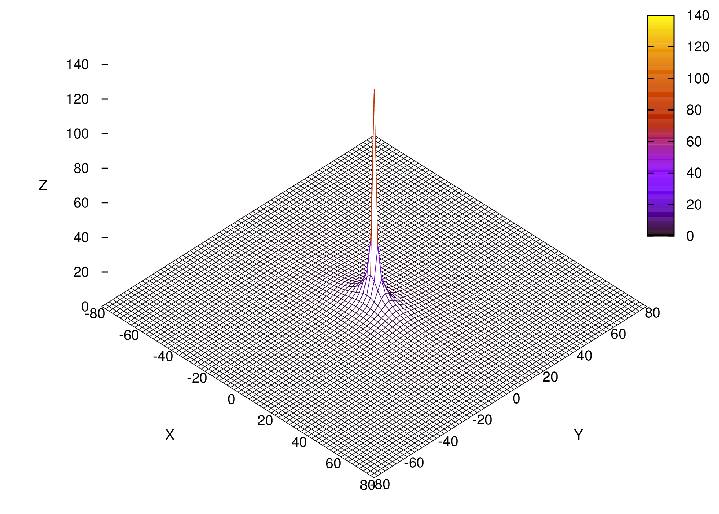

In [8]:
plt.figure(figsize=(12,12))
plotutil.plotDensityGnuplot(fitLensInfo);

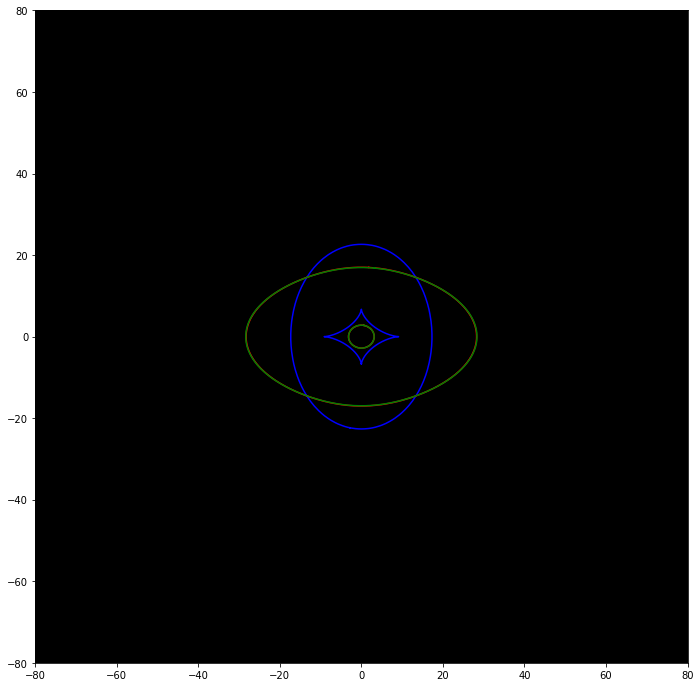

In [9]:
plt.figure(figsize=(12,12))
plotutil.plotImagePlane(fitLensInfo);

orig = lensInfo["imageplane"].getCriticalLines()
for c in orig:
    plt.plot(np.array(c)[:,0]/ANGLE_ARCSEC, np.array(c)[:,1]/ANGLE_ARCSEC, color="green")